### Задание
### Вопросы по заданию
#### В этом разделе можно задать вопросы и получить ответ.
#### Преподаватель: Даниил Корбут, Наталья Баданина, Александр Миленькин, Анастасия Успенская
#### Задание к домашней работе

##### Теперь решаем задачу регрессии - предскажем цены на недвижимость.
* Использовать датасет www.kaggle.com...iques/data (train.csv)
* Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
* Построить случайный лес, вывести важность признаков
* Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
* Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
* Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
* В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn import svm
from sklearn.preprocessing import StandardScaler


In [2]:
data = pd.read_csv('train.csv').drop('Id', axis=1)
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

##### Подготовка данных для оценки

##### Заменим, исходя из значений столбцов data_description, отдельные категориальные данные на порядковые

In [4]:
Street_mapping = {'Pave':0, 'Grvl':1} # Тип подъезда к собственности
data['Street'] = data['Street'].map(Street_mapping)

Alley_mapping = {'Pave':1, 'Grvl':2} # Тип подъездной аллеи к собственности
data['Alley'] = data['Alley'].map(Alley_mapping)
data['Alley'] = data.Alley.fillna(0).astype(int)

LotShape_mapping = {'Reg':3, 'IR1':2,'IR2': 1, 'IR3':0} # General shape of property
data['LotShape'] = data['LotShape'].map(LotShape_mapping)

LandContour_mapping = {'Lvl':3, 'Bnk':2,'HLS': 1, 'Low':0} # Flatness of the property
data['LandContour'] = data['LandContour'].map(LandContour_mapping)

Utilities_mapping = {'AllPub':3, 'NoSewr':2,'NoSeWa': 1, 'ELO':0} #Type of utilities available
data['Utilities'] = data['Utilities'].map(Utilities_mapping)

ExterQual_mapping  = {'Ex':4, 'Gd':3, 'TA':2, 'Fa': 1, 'Po':0} # качество материала экстерьера
data['ExterQual'] = data['ExterQual'].map(ExterQual_mapping)

ExterCond_mapping  = {'Ex':4, 'Gd':3, 'TA':2, 'Fa': 1, 'Po':0} # текущее состояние материала снаружи
data['ExterCond'] = data['ExterCond'].map(ExterCond_mapping)

BsmtQual_mapping  = {'Ex':5, 'Gd':4, 'TA':3, 'Fa': 2, 'Po':1} # высотa цоколя
data['BsmtQual'] = data['BsmtQual'].map(BsmtQual_mapping)
data['BsmtQual'] = data.BsmtQual.fillna(0).astype(int)

BsmtCond_mapping  = {'Ex':5, 'Gd':4, 'TA':3, 'Fa': 2, 'Po':1} # качество цоколя
data['BsmtCond'] = data['BsmtCond'].map(BsmtCond_mapping)
data['BsmtCond'] = data.BsmtCond.fillna(0).astype(int)

BsmtExposure_mapping  = {'Gd':4, 'Av':3, 'Mn': 2, 'No':1} # отношение цоколя к уровню дорожки и сада
data['BsmtExposure'] = data['BsmtExposure'].map(BsmtExposure_mapping)
data['BsmtExposure'] = data.BsmtExposure.fillna(0).astype(int)

BsmtFinType1_mapping  = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ': 2, 'Unf':1} # Rating of basement finished area
data['BsmtFinType1'] = data['BsmtFinType1'].map(BsmtFinType1_mapping)
data['BsmtFinType1'] = data.BsmtFinType1.fillna(0).astype(int)

BsmtFinType2_mapping  = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ': 2, 'Unf':1} # Rating of basement finished area (if multiple types)
data['BsmtFinType2'] = data['BsmtFinType2'].map(BsmtFinType2_mapping)
data['BsmtFinType2'] = data.BsmtFinType2.fillna(0).astype(int)

HeatingQC_mapping  = {'Ex':4, 'Gd':3, 'TA':2, 'Fa': 1, 'Po':0} # Heating quality and condition
data['HeatingQC'] = data['HeatingQC'].map(HeatingQC_mapping)

CentralAir_mapping  = {'Y':1, 'N':0} # Central air conditioning
data['CentralAir'] = data['CentralAir'].map(CentralAir_mapping)

Electrical_mapping  = {'SBrkr':5, 'FuseA':4, 'FuseF':3, 'FuseP': 2, 'Mix':1} # Electrical system
data['Electrical'] = data['Electrical'].map(Electrical_mapping)
data['Electrical'] = data.Electrical.fillna(0).astype(int)

KitchenQual_mapping  = {'Ex':4, 'Gd':3, 'TA':2, 'Fa': 1, 'Po':0} # Kitchen quality
data['KitchenQual'] = data['KitchenQual'].map(KitchenQual_mapping)

Functional_mapping  = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev': 1, 'Sal':0} # Home functionality (Assume typical unless deductions are warranted)
data['Functional'] = data['Functional'].map(Functional_mapping)

FireplaceQu_mapping  = {'Ex':5, 'Gd':4, 'TA':3, 'Fa': 2, 'Po':1} # Fireplace quality
data['FireplaceQu'] = data['FireplaceQu'].map(FireplaceQu_mapping)
data['FireplaceQu'] = data.FireplaceQu.fillna(0).astype(int)

GarageFinish_mapping  = {'Fin':4, 'TA':3, 'RFn': 2, 'Unf':1} # Interior finish of the garage
data['GarageFinish'] = data['GarageFinish'].map(GarageFinish_mapping)
data['GarageFinish'] = data.GarageFinish.fillna(0).astype(int)

GarageQual_mapping  = {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa': 2, 'Po': 1} # Garage quality
data['GarageQual'] = data['GarageQual'].map(GarageQual_mapping)
data['GarageQual'] = data.GarageQual.fillna(0).astype(int)

GarageCond_mapping  = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1} # Garage condition
data['GarageCond'] = data['GarageCond'].map(GarageCond_mapping)
data['GarageCond'] = data.GarageCond.fillna(0).astype(int)

PavedDrive_mapping  = {'Y':3, 'P': 2, 'N':1} # Paved driveway
data['PavedDrive'] = data['PavedDrive'].map(PavedDrive_mapping)

PoolQC_mapping  = {'Ex':4, 'Gd':3, 'TA':2, 'Fa': 1} # Pool quality
data['PoolQC'] = data['PoolQC'].map(PoolQC_mapping)
data['PoolQC'] = data.PoolQC.fillna(0).astype(int)

Fence_mapping  = {'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw': 1} # Fence quality
data['Fence'] = data['Fence'].map(Fence_mapping)
data['Fence'] = data.Fence.fillna(0).astype(int)



##### Заполним недостающие данные по другим признакам

In [5]:
data['MasVnrArea'] = data.MasVnrArea.fillna(0).astype(int) # Площадь облицовки каменной кладкой в квадратных футах
data['GarageYrBlt'] = data.GarageYrBlt.fillna(0).astype(int) # Year garage was built
data['LotFrontage'] = data.LotFrontage.fillna(0).astype(int) # Linear feet of street connected to property
data['GarageType'] = data.GarageType.fillna('No Garage') # Тип гаража
data['GarageYrBlt'] = data.GarageYrBlt.fillna('0') # Год постройки гаража
data['MiscFeature'] = data.MiscFeature.fillna('NaN') # Прочие функции, не включенные в другие категории
data['MasVnrType'] = data.MasVnrType.fillna('NaN') # Тип облицовки кладки

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data['MSSubClass'] = le.fit_transform(data['MSSubClass'].values)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   int64 
 1   MSZoning       1460 non-null   object
 2   LotFrontage    1460 non-null   int32 
 3   LotArea        1460 non-null   int64 
 4   Street         1460 non-null   int64 
 5   Alley          1460 non-null   int32 
 6   LotShape       1460 non-null   int64 
 7   LandContour    1460 non-null   int64 
 8   Utilities      1460 non-null   int64 
 9   LotConfig      1460 non-null   object
 10  LandSlope      1460 non-null   object
 11  Neighborhood   1460 non-null   object
 12  Condition1     1460 non-null   object
 13  Condition2     1460 non-null   object
 14  BldgType       1460 non-null   object
 15  HouseStyle     1460 non-null   object
 16  OverallQual    1460 non-null   int64 
 17  OverallCond    1460 non-null   int64 
 18  YearBuilt      1460 non-null

In [8]:
Y = data.SalePrice
Y = le.fit_transform(Y.values)
Y.shape

(1460,)

In [9]:
data = data.drop('SalePrice', axis = 1)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   int64 
 1   MSZoning       1460 non-null   object
 2   LotFrontage    1460 non-null   int32 
 3   LotArea        1460 non-null   int64 
 4   Street         1460 non-null   int64 
 5   Alley          1460 non-null   int32 
 6   LotShape       1460 non-null   int64 
 7   LandContour    1460 non-null   int64 
 8   Utilities      1460 non-null   int64 
 9   LotConfig      1460 non-null   object
 10  LandSlope      1460 non-null   object
 11  Neighborhood   1460 non-null   object
 12  Condition1     1460 non-null   object
 13  Condition2     1460 non-null   object
 14  BldgType       1460 non-null   object
 15  HouseStyle     1460 non-null   object
 16  OverallQual    1460 non-null   int64 
 17  OverallCond    1460 non-null   int64 
 18  YearBuilt      1460 non-null

In [11]:
cat_feat = list(data.dtypes[data.dtypes == object].index) + ['MSSubClass']
cat_feat

['MSZoning',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'GarageType',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'MSSubClass']

In [12]:
# Отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]
num_feat

['LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscVal',
 'MoSold',
 'YrSold']

In [13]:
# Создаем дамми-переменные для категорий
dummy = pd.get_dummies(data[cat_feat], columns=cat_feat)

In [14]:
X = pd.concat([data[num_feat], dummy], axis=1)
X

,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,OverallQual,OverallCond,YearBuilt,...,MSSubClass_5,MSSubClass_6,MSSubClass_7,MSSubClass_8,MSSubClass_9,MSSubClass_10,MSSubClass_11,MSSubClass_12,MSSubClass_13,MSSubClass_14
0,65,8450,0,0,3,3,3,7,5,2003,...,1,0,0,0,0,0,0,0,0,0
1,80,9600,0,0,3,3,3,6,8,1976,...,0,0,0,0,0,0,0,0,0,0
2,68,11250,0,0,2,3,3,7,5,2001,...,1,0,0,0,0,0,0,0,0,0
3,60,9550,0,0,2,3,3,7,5,1915,...,0,1,0,0,0,0,0,0,0,0
4,84,14260,0,0,2,3,3,8,5,2000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62,7917,0,0,3,3,3,6,5,1999,...,1,0,0,0,0,0,0,0,0,0
1456,85,13175,0,0,3,3,3,6,6,1978,...,0,0,0,0,0,0,0,0,0,0
1457,66,9042,0,0,3,3,3,7,9,1941,...,0,1,0,0,0,0,0,0,0,0
1458,68,9717,0,0,3,3,3,5,6,1950,...,0,0,0,0,0,0,0,0,0,0


In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 231 entries, LotFrontage to MSSubClass_14
dtypes: int32(16), int64(43), uint8(172)
memory usage: 827.1 KB


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0) #, stratify=Y)

#### Построим случайный лес и выведем важность признаков

In [17]:
from sklearn.ensemble import RandomForestRegressor
lr_rf = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=5, random_state=1, n_jobs=-1)
lr_rf.fit(X_train, y_train)   

RandomForestRegressor(max_depth=5, n_estimators=1000, n_jobs=-1, random_state=1)

##### Построим график остатков

In [18]:
def residuals(y_train_pred, y_test_pred):
    plt.scatter(y_train_pred,  y_train_pred - y_train,
                c='steelblue', marker='o', edgecolor='white',
                label='Training data')
    plt.scatter(y_test_pred,  y_test_pred - y_test,
                c='limegreen', marker='s', edgecolor='white',
                label='Test data')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=10, xmax=700, color='black', lw=2)
    plt.xlim([10, 700])
    plt.tight_layout()
    plt.show()


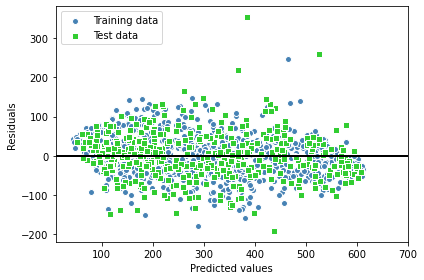

In [19]:
y_train_pred = lr_rf.predict(X_train)
y_test_pred = lr_rf.predict(X_test)
residuals(y_train_pred, y_test_pred)

##### Посчитаем оценки верности

In [20]:
# k-блочная перекрёстная проверка
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=lr_rf, X=X_train, y=y_train, cv=10, n_jobs=1)
print('Оценки перекрёстно-проверочной верности: %s' % scores)
print('Перекрёстно-проверочная верность: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Оценки перекрёстно-проверочной верности: [0.82685889 0.83910342 0.81775421 0.88710454 0.86036741 0.88584696
 0.83054597 0.87231054 0.85233115 0.83887297]
Перекрёстно-проверочная верность: 0.851 +/- 0.023


In [21]:
# Средневзвешенная квадратичная ошибка и коэффициент детерминации
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 2439.510, test: 3590.508
R^2 train: 0.915, test: 0.876


#### Определим важность признаков и выведем для наглядности первые 15

In [22]:
imp = pd.Series(lr_rf.feature_importances_)
imp2 = imp.sort_values(ascending=False).iloc[:15]
imp2

7      0.636403
29     0.132017
22     0.044090
44     0.030735
43     0.019195
26     0.017354
18     0.015749
9      0.009379
42     0.008334
1      0.007700
41     0.005683
14     0.005321
17     0.005160
194    0.004766
36     0.003987
dtype: float64

#### Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
##### Готовим признаки

In [25]:
X2_train = X_train.iloc[:, imp2.index]
X2_test = X_test.iloc[:, imp2.index]
X2_test

,OverallQual,GrLivArea,TotalBsmtSF,GarageArea,GarageCars,1stFlrSF,BsmtFinSF1,YearBuilt,GarageFinish,LotArea,GarageYrBlt,BsmtQual,BsmtFinType1,GarageType_Detchd,KitchenQual
529,6,2515,2035,484,2,2515,1219,1957,2,32668,1975,3,3,0,2
491,6,1578,806,240,1,958,403,1941,1,9490,1941,3,4,0,1
459,5,1203,709,352,1,979,185,1950,1,7015,1950,3,2,1,3
279,7,2022,1160,505,2,1156,392,1977,4,10005,1977,4,4,0,2
655,6,1092,525,264,1,525,0,1971,1,1680,1971,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,7,1363,1385,439,2,1363,226,1954,1,39104,1954,4,2,0,2
445,6,1689,1436,480,2,1689,0,1956,1,9855,1956,3,1,0,2
654,8,2113,2109,839,3,2113,1696,1995,4,10437,1995,4,6,0,3
1280,7,1573,1573,544,2,1573,788,2002,2,9808,2002,4,6,0,3


##### Обучаем регрессоры: Линейная регрессия, Модель эластичной сети(ElasticNet), Метод опорных векторов, Стохастический градиентный спуск, Дерево решений, Случайный лес 

##### Объединяем классификаторы в ансамбль и обучаем стекинг

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline


In [29]:
estimators = [
    ('lr', make_pipeline(StandardScaler(), LinearRegression())),
    ('en', make_pipeline(StandardScaler(), ElasticNet())),
    ('svr', make_pipeline(StandardScaler(), SVR())),
    ('sgd', make_pipeline(StandardScaler(), SGDRegressor())),
    ('dt', DecisionTreeRegressor(max_depth=3, criterion='mse', random_state=1)),
    ('lr_rf', RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=5, random_state=1, n_jobs=-1)) 
     ]

In [36]:
reg = StackingRegressor(estimators=estimators, 
                        final_estimator=RandomForestRegressor(max_depth=3))

In [37]:
reg.fit(X2_train, y_train)

StackingRegressor(estimators=[('lr',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('linearregression',
                                                LinearRegression())])),
                              ('en',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('elasticnet', ElasticNet())])),
                              ('svr',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('svr', SVR())])),
                              ('sgd',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                

In [38]:
def cvs(X2_train, X2_test, y_train, y_test, reg):
    print('Тренировочные данные')
    scores_train = cross_val_score(estimator=reg, X=X2_train, y=y_train, cv=10, n_jobs=1)
    print('Оценки перекрёстно-проверочной верности: %s' % scores_train)
    print('Перекрёстно-проверочная верность: %.3f +/- %.3f' % (np.mean(scores_train), np.std(scores_train)))
    
    print()
    
    print('Тестовые данные')
    scores_test = cross_val_score(estimator=reg, X=X2_test, y=y_test, cv=10, n_jobs=1)
    print('Оценки перекрёстно-проверочной верности: %s' % scores_test)
    print('Перекрёстно-проверочная верность: %.3f +/- %.3f' % (np.mean(scores_test), np.std(scores_test)))
   
    y_train_pred = reg.predict(X2_train)
    y_test_pred = reg.predict(X2_test)
    print()
    print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
    print()
    print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

In [39]:
print("Линейная регрессия")
cvs(X2_train, X2_test, y_train, y_test, reg.named_estimators_['lr'])
print()
print("Модель эластичной сети(ElasticNet)")
cvs(X2_train, X2_test, y_train, y_test, reg.named_estimators_['en'])
print()
print("Метод опорных векторов")
cvs(X2_train, X2_test, y_train, y_test, reg.named_estimators_['svr'])
print()
print("Стохастический градиентный спуск")
cvs(X2_train, X2_test, y_train, y_test, reg.named_estimators_['sgd'])
print()
print('Дерево решений')
cvs(X2_train, X2_test, y_train, y_test, reg.named_estimators_['dt'])
print()
print('Случайный лес')
cvs(X2_train, X2_test, y_train, y_test, reg.named_estimators_['lr_rf'])
print()
print('Стекинг')
cvs(X2_train, X2_test, y_train, y_test, reg)


Линейная регрессия
Тренировочные данные
Оценки перекрёстно-проверочной верности: [0.89035759 0.69448972 0.82055933 0.9039243  0.89679704 0.82045322
 0.86768087 0.88944386 0.88842293 0.83562869]
Перекрёстно-проверочная верность: 0.851 +/- 0.060

Тестовые данные
Оценки перекрёстно-проверочной верности: [ 0.84534653  0.8875207   0.87008915  0.8433064   0.79594049 -0.02654738
  0.81657342  0.84234835  0.89426674  0.86520556]
Перекрёстно-проверочная верность: 0.763 +/- 0.265

MSE train: 3994.496, test: 6043.252

R^2 train: 0.861, test: 0.792

Модель эластичной сети(ElasticNet)
Тренировочные данные
Оценки перекрёстно-проверочной верности: [0.87286731 0.74480425 0.786794   0.88699896 0.88087709 0.79551113
 0.86204148 0.85960546 0.8636898  0.81360487]
Перекрёстно-проверочная верность: 0.837 +/- 0.046

Тестовые данные
Оценки перекрёстно-проверочной верности: [0.84556657 0.86085786 0.86654382 0.818616   0.78195397 0.15902949
 0.8259704  0.86803035 0.88519976 0.85232372]
Перекрёстно-проверочная в

### Вывод: Стекинг показал лучшую верность по сравнению с отдельными моделями

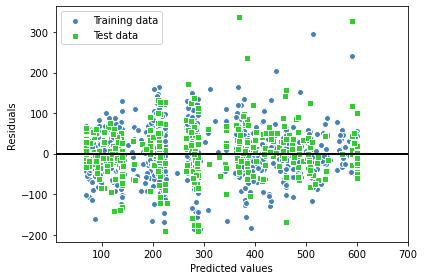

In [56]:
# График остатков для Stacking
y_train_pred_stack = reg.predict(X2_train)
y_test_pred_stack = reg.predict(X2_test)
residuals(y_train_pred_stack, y_test_pred_stack)